In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import yfinance as yf
print('All packages loaded')

All packages loaded


In [2]:
# URL of the raw Excel file in the GitHub repository
github_excel_url = 'https://github.com/YuriAntonelli/Short-Rate-Forecasting/raw/main/treasury_bill_data.xlsx'

# Introduction
In this notebook we calibrate a number of models on 13 Weeks Treasury Bill Rates, with the aim to compare their performance with a simple Random Walk model. The models that we are going to use can be categorized in 2 different field of study:
1. **Mathematical Finance**: Vasicek, CIR
2. **Machine Learning**: Random Forest, LSTM

For each model we perform a **rolling window** approach, with a number of **90** observations for each step.

In [3]:
# Read the Excel file into a DataFrame
df = pd.read_excel(github_excel_url, index_col='Date')

In [4]:
# keep dates and save the data in a new df
dates = df.index
US_ir = df.Close / 100
US_ir.head()

Date
2021-08-06    0.00043
2021-08-09    0.00045
2021-08-10    0.00050
2021-08-11    0.00045
2021-08-12    0.00043
Name: Close, dtype: float64

**Time Series Plot:**

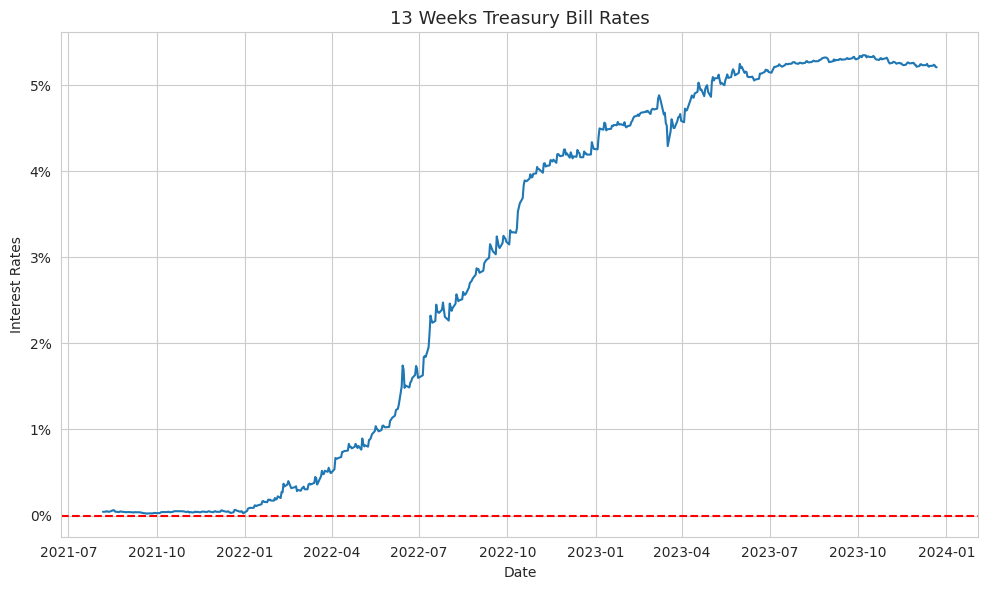

In [5]:
plt.figure(figsize=(10, 6))
# Set Seaborn style
sns.set_style("whitegrid")
# Create the time series plot using Seaborn
sns.lineplot(data=US_ir)
# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Interest Rates')
plt.title('13 Weeks Treasury Bill Rates', fontsize=13)
# Show grid
plt.grid(True)
# Function to format y-axis labels
def percentage(x, pos):
    return f'{x:.0%}'  # Change the format as desired, here it shows as whole percentage without decimals
# Apply the custom formatter to the y-axis ticks
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(percentage))
# Add a red line at y=0
plt.axhline(y=0, color='red', linestyle='--')  # You can customize linestyle as needed
# Show plot
plt.tight_layout()
plt.show()

# Random Walk
This simple model can be mathematically expressed as follows:

$i_{t+\delta t} = i_{t} + \epsilon$

Where $\epsilon$ is a disturbance term with zero mean.
This allows us to employ the **Random Walk** as a straightforward benchmark, where the optimal prediction for rates at time $t+1$ is merely the rates at time $t$. In essence, our time series is inherently unpredictable, as there is no additional information that can be harnessed for forecasting purposes.

In [6]:
df = US_ir.copy()
df = pd.DataFrame({'series1': df})
df = df.join(US_ir.shift(1),  how='left')
df.columns = ['rates t', 'rates t-1']
df = df.dropna()
df.reset_index(inplace=True)
df = df.iloc[:, 1:]
print(df.head())

# split y and X
y = df['rates t']
X = df[['rates t-1']]

   rates t  rates t-1
0  0.00045    0.00043
1  0.00050    0.00045
2  0.00045    0.00050
3  0.00043    0.00045
4  0.00045    0.00043


In [7]:
# Variables of interest for the calibration
ts_length = df.shape[0]
n_obs = 90
max_time_step = 90
dt = 1/252

In [8]:
pred1_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred7_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred30_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred90_v = np.zeros(ts_length-(n_obs+max_time_step-1))

exact1_v = np.zeros(ts_length-(n_obs+max_time_step-1))
exact7_v = np.zeros(ts_length-(n_obs+max_time_step-1))
exact30_v = np.zeros(ts_length-(n_obs+max_time_step-1))
exact90_v = np.zeros(ts_length-(n_obs+max_time_step-1))

"""
create a for loop for the rolling window, but only for those
timeframes where backtesting is possible
"""
for n in range(ts_length-n_obs):

    # by doing that I keep all the observations from n to (n+n_obs-1)
    X_train = X.iloc[n:n+n_obs, :]
    y_train = y.iloc[n:n+n_obs]
    prediction_index = y_train.index[-1]

    # Need to break the loop if my max prediction cannot be backtested
    if (prediction_index + max_time_step) > y.index[-1]:
        break

    # predictions and exact values at 4 time steps
    r0 = y_train.iloc[-1]

    pred1 = r0
    pred7 = r0
    pred30 = r0
    pred90 = r0

    exact1 = y.iloc[prediction_index + 1]
    exact7 = y.iloc[prediction_index + 7]
    exact30 = y.iloc[prediction_index + 30]
    exact90 = y.iloc[prediction_index + 90]

    # store the predictions and the exact values
    pred1_v[n] = pred1
    pred7_v[n] = pred7
    pred30_v[n] = pred30
    pred90_v[n] = pred90

    exact1_v[n] = exact1
    exact7_v[n] = exact7
    exact30_v[n] = exact30
    exact90_v[n] = exact90

In [9]:
# Create a dataframe with all the predictions and one with all exact values
pred_RW = {
    '1 step pred': pred1_v,
    '7 step pred': pred7_v,
    '30 step pred': pred30_v,
    '90 step pred': pred90_v
}

exact_rates = {
    '1 step exact': exact1_v,
    '7 step exact': exact7_v,
    '30 step exact': exact30_v,
    '90 step exact': exact90_v
}

pred_RW = pd.DataFrame(pred_RW)
exact_rates = pd.DataFrame(exact_rates)
pred_RW.index = dates[n_obs:pred_RW.shape[0]+n_obs]
exact_rates.index = dates[n_obs:pred_RW.shape[0]+n_obs]

In [10]:
# Compute MSE
SE_RW = pd.DataFrame(columns=['1 step ahead', '7 steps ahead', '30 steps ahead', '90 steps ahead'])
for n in range(4):
    SE_RW[SE_RW.columns[n]] = (pred_RW.iloc[:, n] - exact_rates.iloc[:, n])**2

SE_RW.head()

,1 step ahead,7 steps ahead,30 steps ahead,90 steps ahead
Date,,,,
2021-12-14,8.999992e-10,9.999996e-09,0.000002,0.000056
2021-12-15,1.000000e-08,4.000001e-10,0.000002,0.000062
2021-12-16,2.500001e-09,2.250000e-08,0.000002,0.000060
2021-12-17,6.399999e-09,2.250001e-08,0.000003,0.000057
2021-12-20,7.289999e-08,1.690000e-08,0.000002,0.000059


# Vasicek Model

In [11]:
# Arrays to store predictions
pred1_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred7_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred30_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred90_v = np.zeros(ts_length-(n_obs+max_time_step-1))

In [12]:
for n in range(ts_length-n_obs):

    # linear regression needed for the Vasicek calibration
    model = LinearRegression()

    # by doing that I keep all the observations from n to (n+n_obs-1)
    X_train = X.iloc[n:n+n_obs, :]
    y_train = y.iloc[n:n+n_obs]
    prediction_index = y_train.index[-1]

    # Need to break the loop if my max prediction cannot be backtested
    if (prediction_index + max_time_step) > y.index[-1]:
        break

    # fit the model
    model.fit(X_train, y_train)

    # get parameters of the linear regression
    intercept = model.intercept_
    slope = model.coef_[0]

    # get the parameter of interest for Vasicek
    k = (1-slope)/dt
    theta = intercept / (1-slope)

    # predictions at 4 time steps
    r0 = y.iloc[prediction_index]

    pred1 = r0 * np.exp(-k*dt) + theta * (1 - np.exp(-k*dt))
    pred7 = r0 * np.exp(-k*7*dt) + theta * (1 - np.exp(-k*7*dt))
    pred30 = r0 * np.exp(-k*30*dt) + theta * (1 - np.exp(-k*30*dt))
    pred90 = r0 * np.exp(-k*90*dt) + theta * (1 - np.exp(-k*90*dt))

    # store the predictions
    pred1_v[n] = pred1
    pred7_v[n] = pred7
    pred30_v[n] = pred30
    pred90_v[n] = pred90

In [13]:
# Create a dataframe with all the predictions
pred_vsk = {
    '1 step pred': pred1_v,
    '7 step pred': pred7_v,
    '30 step pred': pred30_v,
    '90 step pred': pred90_v
}

pred_VSK = pd.DataFrame(pred_vsk)
pred_VSK.index = dates[n_obs:pred_RW.shape[0]+n_obs]

In [14]:
# Compute MSE
SE_VSK = pd.DataFrame(columns=['1 step ahead', '7 steps ahead', '30 steps ahead', '90 steps ahead'])
for n in range(4):
    SE_VSK[SE_VSK.columns[n]] = (pred_VSK.iloc[:, n] - exact_rates.iloc[:, n])**2

SE_VSK.head()

,1 step ahead,7 steps ahead,30 steps ahead,90 steps ahead
Date,,,,
2021-12-14,4.337599e-10,2.010159e-08,0.000002,0.000057
2021-12-15,8.979036e-09,1.389653e-11,0.000002,0.000063
2021-12-16,3.447883e-09,1.239090e-08,0.000002,0.000059
2021-12-17,4.189832e-09,6.477027e-09,0.000003,0.000055
2021-12-20,7.049908e-08,2.247248e-08,0.000002,0.000059


# CIR Model
Before calibrating the CIR model, it is necessary to shift all the interest rates into positive values.

In [15]:
# Arrays to store predictions
pred1_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred7_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred30_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred90_v = np.zeros(ts_length-(n_obs+max_time_step-1))

In [16]:
for n in range(ts_length-n_obs):

    # linear regression needed for CIR calibration
    model = LinearRegression(fit_intercept=False)

    # by doing that I keep all the observations from n to (n+n_obs-1)
    X_train = X['rates t-1'].iloc[n:n+n_obs]
    y_train = y.iloc[n:n+n_obs]
    prediction_index = y_train.index[-1]

    # Need to break the loop if my max prediction cannot be backtested
    if (prediction_index + max_time_step) > y.index[-1]:
        break

    y_cir = (y_train - X_train) / np.sqrt(X_train)
    z1 = dt / np.sqrt(X_train)
    z2 = dt * np.sqrt(X_train)
    X_cir = np.column_stack((z1, z2))

    model.fit(X_cir, y_cir)

    # Calculate the predicted values (y_hat), residuals and the parameters
    beta1 = model.coef_[0]
    beta2 = model.coef_[1]

    # get the parameter of interest for CIR
    k = -beta2
    theta = beta1/k

    # predictions at 4 time steps
    r0 = y.iloc[prediction_index]

    pred1 = r0 * np.exp(-k*dt) + theta * (1 - np.exp(-k*dt))
    pred7 = r0 * np.exp(-k*7*dt) + theta * (1 - np.exp(-k*7*dt))
    pred30 = r0 * np.exp(-k*30*dt) + theta * (1 - np.exp(-k*30*dt))
    pred90 = r0 * np.exp(-k*90*dt) + theta * (1 - np.exp(-k*90*dt))

    # store the predictions
    pred1_v[n] = pred1
    pred7_v[n] = pred7
    pred30_v[n] = pred30
    pred90_v[n] = pred90

In [17]:
# Create a dataframe with all the predictions
pred_CIR = {
    '1 step pred': pred1_v,
    '7 step pred': pred7_v,
    '30 step pred': pred30_v,
    '90 step pred': pred90_v
}

pred_CIR = pd.DataFrame(pred_CIR)
pred_CIR.index = dates[n_obs:pred_RW.shape[0]+n_obs]

In [18]:
# Compute MSE
SE_CIR = pd.DataFrame(columns=['1 step ahead', '7 steps ahead', '30 steps ahead', '90 steps ahead'])
for n in range(4):
    SE_CIR[SE_CIR.columns[n]] = (pred_CIR.iloc[:, n] - exact_rates.iloc[:, n])**2

SE_CIR.head()

,1 step ahead,7 steps ahead,30 steps ahead,90 steps ahead
Date,,,,
2021-12-14,5.102421e-10,1.860392e-08,0.000002,0.000057
2021-12-15,9.153119e-09,1.175202e-12,0.000002,0.000063
2021-12-16,3.262565e-09,1.350307e-08,0.000002,0.000059
2021-12-17,4.532037e-09,7.829989e-09,0.000003,0.000055
2021-12-20,7.087659e-08,2.185151e-08,0.000002,0.000059


# Random Forest

In [19]:
# array for teh 1-step ahead forecast
pred1_v = np.zeros(ts_length-(n_obs+max_time_step-1))

# Specify the number of trees in the bagging ensemble
n_estimators = 100
# Specify the number of lags
num_lags = 10

In [20]:
for n in range(ts_length - n_obs):
    # Choose the base model for bagging (a decision tree regressor)
    base_model = DecisionTreeRegressor(random_state=0)

    # Create the BaggingRegressor with the base model
    model = BaggingRegressor(estimator=base_model, n_estimators=n_estimators, random_state=0)

    # By doing that I keep all the observations from n to (n+n_obs-1)
    y_train = y[n:n + n_obs]
    prediction_index = y_train.index[-1]

    # Need to break the loop if my max prediction cannot be backtested
    if (prediction_index + max_time_step) > y.index[-1]:
        break

    # Fill the lagged data dataframe
    lagged_data = pd.DataFrame()
    for lag in range(1, num_lags + 1):
        lagged_data[f"Lag_{lag}"] = y_train.shift(lag)

    # Create initial df
    lagged_data = lagged_data.dropna()
    target = pd.DataFrame(y_train[num_lags:])

    # Reset indexes
    lagged_data.reset_index(inplace=True)
    target.reset_index(inplace=True)
    lagged_data = lagged_data.iloc[:, 1:]
    target = pd.DataFrame(target.iloc[:, 1])

    # Create the lagged data to predict t+1 observation
    X_test = lagged_data.iloc[-1, :]
    new_lag_1 = target.iloc[-1]
    X_test_new = pd.concat([pd.Series(new_lag_1), X_test[:-1]])
    X_test_new.index = X_test.index

    # Train a BaggingRegressor model
    model.fit(lagged_data, np.ravel(target))

    # Store the predictions
    pred1_v[n] = model.predict(X_test_new.to_frame().T)

In [21]:
# Create a dataframe with all the predictions
pred_rf = {
    '1 step pred': pred1_v,
}

pred_rf = pd.DataFrame(pred_rf)
pred_rf.index = dates[n_obs:pred_RW.shape[0]+n_obs]

In [22]:
# Compute MSE
SE_rf = pd.DataFrame(columns=['1 step ahead'])
SE_rf['1 step ahead'] = (pred_rf.iloc[:, 0] - exact_rates.iloc[:, 0])**2

SE_rf.head()

,1 step ahead
Date,
2021-12-14,3.422495e-10
2021-12-15,1.336336e-08
2021-12-16,1.338649e-08
2021-12-17,9.761437e-09
2021-12-20,7.075599e-08


# LSTM

In [23]:
# Variables of interest for the calibration
pred1_v = np.zeros(ts_length-(n_obs+max_time_step-1))

In [ ]:
counter = 0
for n in range(ts_length-n_obs):

    # by doing that I keep all the observations from n to (n+n_obs-1)
    y_train = y[n:n+n_obs]
    prediction_index = y_train.index[-1]
    interest_rates = y_train.values

    # Need to break the loop if my max prediction cannot be backtested
    if (prediction_index + max_time_step) > y.index[-1]:
        break

    print(f'this is the loop n {counter}')
    counter += 1
    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    interest_rates_normalized = scaler.fit_transform(interest_rates.reshape(-1, 1))

    # Split the data into input (X) and output (y)
    X_lstm = interest_rates_normalized[:-1]
    y_lstm = interest_rates_normalized[1:]

    # Reshape data for LSTM model (samples, time steps, features)
    X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], 1, 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=5, input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_lstm, y_lstm, epochs=25, batch_size=1, verbose=1)

    # Predict using the trained model the rates at t+1
    #last_observations = interest_rates_normalized.reshape(len(interest_rates_normalized), 1, 1)
    predicted_next_interests = model.predict(y_lstm)
    predicted_next_interests = scaler.inverse_transform(predicted_next_interests)

    # store only the last prediction, which has as input the last known rate
    pred1_v[n] = predicted_next_interests[-1][0]

this is the loop n 0
Epoch 1/25
89/89 [==============================] - 2s 3ms/step - loss: 0.1966
Epoch 2/25
89/89 [==============================] - 0s 3ms/step - loss: 0.0832
Epoch 3/25
89/89 [==============================] - 0s 3ms/step - loss: 0.0353
Epoch 4/25
89/89 [==============================] - 0s 2ms/step - loss: 0.0236
Epoch 5/25
89/89 [==============================] - 0s 3ms/step - loss: 0.0216
Epoch 6/25
89/89 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 7/25
89/89 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 8/25
89/89 [==============================] - 0s 3ms/step - loss: 0.0196
Epoch 9/25
89/89 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 10/25
89/89 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 11/25
89/89 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 12/25
89/89 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 13/25
89/89 [=========

3/3 [==============================] - 0s 6ms/step
this is the loop n 5
Epoch 1/25
89/89 [==============================] - 2s 6ms/step - loss: 0.2322
Epoch 2/25
89/89 [==============================] - 0s 5ms/step - loss: 0.1195
Epoch 3/25
89/89 [==============================] - 1s 6ms/step - loss: 0.0576
Epoch 4/25
89/89 [==============================] - 1s 6ms/step - loss: 0.0351
Epoch 5/25
89/89 [==============================] - 0s 5ms/step - loss: 0.0299
Epoch 6/25
89/89 [==============================] - 0s 5ms/step - loss: 0.0286
Epoch 7/25
89/89 [==============================] - 0s 5ms/step - loss: 0.0276
Epoch 8/25
89/89 [==============================] - 0s 5ms/step - loss: 0.0268
Epoch 9/25
89/89 [==============================] - 0s 5ms/step - loss: 0.0261
Epoch 10/25
89/89 [==============================] - 0s 6ms/step - loss: 0.0251
Epoch 11/25
89/89 [==============================] - 1s 10ms/step - loss: 0.0244
Epoch 12/25
89/89 [==============================] - 1s 

Streaming output truncated to the last 5000 lines.
89/89 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 23/25
89/89 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 24/25
89/89 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 25/25
3/3 [==============================] - 0s 6ms/step
this is the loop n 324
Epoch 1/25
89/89 [==============================] - 2s 3ms/step - loss: 0.1956
Epoch 2/25
89/89 [==============================] - 0s 3ms/step - loss: 0.0936
Epoch 3/25
89/89 [==============================] - 0s 3ms/step - loss: 0.0461
Epoch 4/25
89/89 [==============================] - 0s 3ms/step - loss: 0.0310
Epoch 5/25
89/89 [==============================] - 0s 3ms/step - loss: 0.0265
Epoch 6/25
89/89 [==============================] - 0s 3ms/step - loss: 0.0239
Epoch 7/25
89/89 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 8/25
89/89 [==============================] - 0s 3ms/step - loss: 0.0185
Epo

In [ ]:
# Create a dataframe with all the predictions
pred_LSTM = {
    '1 step pred': pred1_v,
}

pred_LSTM = pd.DataFrame(pred_LSTM)
pred_LSTM.index = dates[n_obs:pred_RW.shape[0]+n_obs]

In [ ]:
# Compute MSE
SE_LSTM = pd.DataFrame(columns=['1 step ahead'])
SE_LSTM['1 step ahead'] = (pred_LSTM.iloc[:, 0] - exact_rates.iloc[:, 0])**2

SE_LSTM.head()

,1 step ahead
Date,
2021-12-14,9.517074e-11
2021-12-15,8.145405e-09
2021-12-16,4.086437e-09
2021-12-17,2.767283e-09
2021-12-20,6.614015e-08


# Forecasting Comparison
cose da fare:
1. summary di ogni modello (fatto)
2. grafico con +1 e -1 in base a se RW è battuta o meno (fatto)
4. RANKING MODELLI

In [ ]:
SE_RW.describe()

,1 step ahead,7 steps ahead,30 steps ahead,90 steps ahead
count,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02
mean,3.200209e-07,2.578023e-06,2.274667e-05,1.691888e-04
std,8.034475e-07,6.000665e-06,3.139453e-05,1.837303e-04
min,0.000000e+00,0.000000e+00,2.500114e-09,2.499638e-09
25%,6.400020e-09,1.072751e-07,2.146300e-06,2.423117e-05
50%,4.840138e-08,5.929002e-07,9.363700e-06,7.056487e-05
75%,2.303986e-07,2.310398e-06,3.197911e-05,3.092323e-04
max,6.002500e-06,5.183999e-05,1.729225e-04,6.786024e-04


In [ ]:
 # We need to convert any zero error of RW to 0.00000000001
 SE_RW = SE_RW.replace(0, 0.00000000001)
 SE_RW

,1 step ahead,7 steps ahead,30 steps ahead,90 steps ahead
Date,,,,
2021-12-14,8.999992e-10,9.999996e-09,1.876900e-06,5.625000e-05
2021-12-15,1.000000e-08,4.000001e-10,1.638400e-06,6.209440e-05
2021-12-16,2.500001e-09,2.250000e-08,1.904400e-06,5.975290e-05
2021-12-17,6.399999e-09,2.250001e-08,2.992900e-06,5.700250e-05
2021-12-20,7.289999e-08,1.690000e-08,2.160900e-06,5.929000e-05
...,...,...,...,...
2023-08-10,9.001556e-10,1.440020e-08,1.368978e-07,1.849019e-07
2023-08-11,2.500114e-09,9.000126e-08,2.304032e-07,7.289973e-08
2023-08-14,1.000046e-08,6.250048e-08,3.024981e-07,1.599997e-07


In [ ]:
# compute all the scores
F_score_RW = (SE_RW - SE_RW) / SE_RW
F_score_VSK = (SE_RW - SE_VSK) / SE_RW
F_score_CIR = (SE_RW - SE_CIR) / SE_RW
F_score_rf = (SE_RW - SE_rf) / SE_RW
F_score_LSTM = (SE_RW - SE_LSTM) / SE_RW

print(F_score_RW.head())

            1 step ahead  7 steps ahead  30 steps ahead  90 steps ahead
Date                                                                   
2021-12-14           0.0            0.0             0.0             0.0
2021-12-15           0.0            0.0             0.0             0.0
2021-12-16           0.0            0.0             0.0             0.0
2021-12-17           0.0            0.0             0.0             0.0
2021-12-20           0.0            0.0             0.0             0.0


In [ ]:
# we need to eliminate all the dates with RW error = 0, as it will make the other scores = inf
F_score_RW.isna().sum().sum()

0

## Summary of Each Model's Metric

In [ ]:
print(f'{F_score_VSK.describe()} \n ----------------------------- \n {SE_VSK.describe()}')

       1 step ahead  7 steps ahead  30 steps ahead  90 steps ahead
count    420.000000     420.000000      420.000000    4.200000e+02
mean     -32.751425    -410.518216      -10.694125   -2.790064e+03
std      308.223586    7125.538499       99.328647    5.385195e+04
min    -4060.701631 -145571.559565    -1707.574760   -1.102360e+06
25%       -1.432615      -2.672841       -1.770755   -1.280331e+00
50%       -0.110154       0.074118        0.355008    2.991237e-01
75%        0.354661       0.687368        0.800121    7.915557e-01
max        0.999997       0.999996        1.000000    9.998419e-01 
 ----------------------------- 
        1 step ahead  7 steps ahead  30 steps ahead  90 steps ahead
count  4.200000e+02   4.200000e+02    4.200000e+02    4.200000e+02
mean   3.170212e-07   2.359788e-06    2.342957e-05    3.766314e-01
std    7.508250e-07   5.416998e-06    1.212859e-04    7.428566e+00
min    2.513944e-14   6.968489e-12    1.844309e-11    5.211745e-08
25%    9.170760e-09   1.7245

In [ ]:
print(f'{F_score_CIR.describe()} \n ----------------------------- \n {SE_CIR.describe()}')

       1 step ahead  7 steps ahead  30 steps ahead  90 steps ahead
count    420.000000     420.000000      420.000000      420.000000
mean     -28.897726    -502.401045       -9.013033      -27.251477
std      261.056798    8135.541846       96.254243      358.045196
min    -3822.026988 -164446.666809    -1886.961775    -7043.163542
25%       -1.547548      -3.039568       -1.307296       -1.106850
50%       -0.126580      -0.031292        0.426853        0.343076
75%        0.373269       0.724811        0.823984        0.757538
max        0.999895       0.999726        0.999994        1.000000 
 ----------------------------- 
        1 step ahead  7 steps ahead  30 steps ahead  90 steps ahead
count  4.200000e+02   4.200000e+02    4.200000e+02    4.200000e+02
mean   3.139147e-07   2.203167e-06    1.343410e-05    3.509478e-03
std    7.389320e-07   4.846396e-06    3.060873e-05    4.978649e-02
min    1.052765e-12   1.175202e-12    9.778788e-11    2.182804e-11
25%    9.954310e-09   1.5658

In [ ]:
print(f'{F_score_rf.iloc[:,0].describe()} \n ----------------------------- \n {SE_rf.describe()}')

count      420.000000
mean      -208.736173
std       1605.457173
min     -22723.140868
25%         -7.055736
50%         -0.746822
75%          0.361974
max          0.999831
Name: 1 step ahead, dtype: float64 
 ----------------------------- 
        1 step ahead
count  4.200000e+02
mean   5.124738e-07
std    1.199837e-06
min    1.207728e-12
25%    2.148426e-08
50%    1.071923e-07
75%    4.344795e-07
max    1.170256e-05


In [ ]:
print(f'{F_score_LSTM.iloc[:,0].describe()} \n ----------------------------- \n {SE_LSTM.describe()}')

count      420.000000
mean      -264.060965
std       3536.658385
min     -70937.127968
25%         -3.662724
50%         -0.299516
75%          0.367875
max          0.999994
Name: 1 step ahead, dtype: float64 
 ----------------------------- 
        1 step ahead
count  4.200000e+02
mean   4.110676e-07
std    9.427976e-07
min    7.052564e-14
25%    1.904772e-08
50%    9.229072e-08
75%    3.455338e-07
max    9.747694e-06


In [ ]:
ranking1 = [SE_RW.iloc[:,0].mean(), SE_VSK.iloc[:,0].mean(), SE_CIR.iloc[:,0].mean(), SE_rf.iloc[:,0].mean(), SE_LSTM.iloc[:,0].mean()]
ranking1

[3.2002124170051465e-07,
 3.170212095248906e-07,
 3.1391465651497844e-07,
 5.124737876618442e-07,
 4.110675581296738e-07]

In [ ]:
sorted(ranking1)

[3.1391465651497844e-07,
 3.170212095248906e-07,
 3.2002124170051465e-07,
 4.110675581296738e-07,
 5.124737876618442e-07]

## Graph with positive and negative Scores

In [ ]:
# Define some functions for our task


def change_values(val):
    if val > 0:
        return 1
    elif val < 0:
        return -1
    else:
        return 0

#---------------------------------------------------------

def pos_neg_plot(data, title):
    # Creating a figure and axis
    fig, ax = plt.subplots(figsize=(15, 6))

    # Creating an area plot for values of 1 and -1
    x = range(len(data))  # X-axis values (assumed indices)
    y = data.values  # Y-axis values from the DataFrame

    for i, val in enumerate(y):
        if val == 1:
            plt.fill_between(x[i:i+1], 0, 1, color='green')
        elif val == -1:
            plt.fill_between(x[i:i+1], 0, -1, color='red')

    # Customizing plot
    plt.title(title, fontsize=20)
    plt.xlabel('Nr of observations')
    plt.ylabel('Values')

    # Set y-axis ticks to show only -1 and 1
    plt.yticks([-1, 1])

    # Show plot
    plt.tight_layout()  # Adjust layout to prevent cutoff of labels
    plt.show()

### Vasicek

In [ ]:
F_score_VSK_2 = F_score_VSK.applymap(change_values)

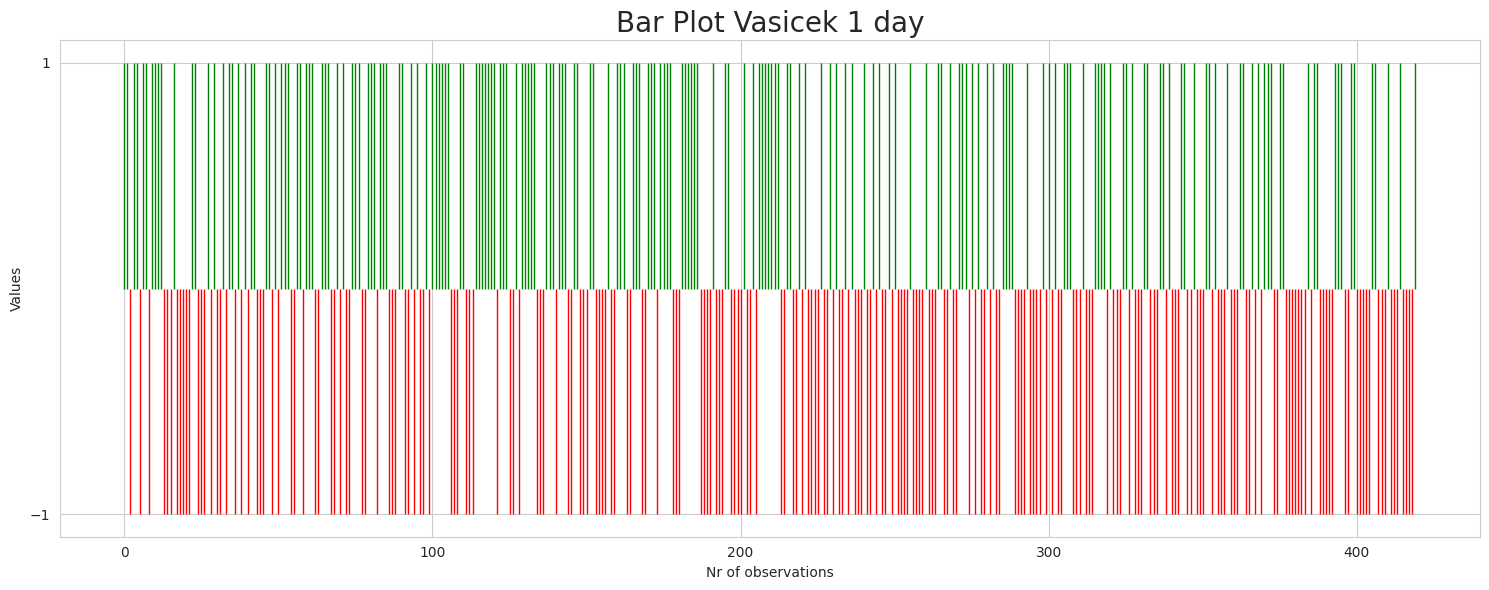

-1    0.528571
 1    0.471429
Name: 1 step ahead, dtype: float64

In [ ]:
# 1 day
pos_neg_plot(F_score_VSK_2.iloc[:, 0], 'Bar Plot Vasicek 1 day')

F_score_VSK_2.iloc[:, 0].value_counts(1)

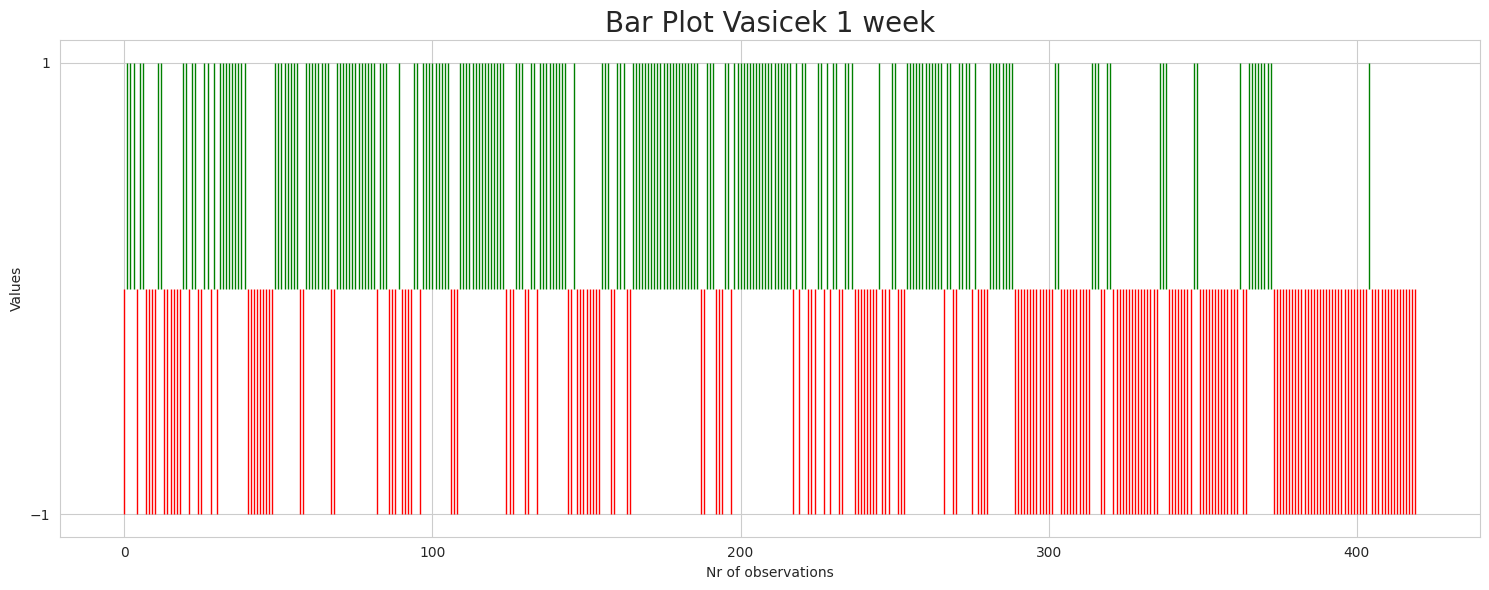

 1    0.504762
-1    0.495238
Name: 7 steps ahead, dtype: float64

In [ ]:
# 1 week
pos_neg_plot(F_score_VSK_2.iloc[:, 1], 'Bar Plot Vasicek 1 week')

F_score_VSK_2.iloc[:, 1].value_counts(1)

In [ ]:
# 1 month
pos_neg_plot(F_score_VSK_2.iloc[:, 2], 'Bar Plot Vasicek 1 month')

F_score_VSK_2.iloc[:, 2].value_counts(1)

In [ ]:
# 3 months
pos_neg_plot(F_score_VSK_2.iloc[:, 3], 'Bar Plot Vasicek 3 months')

F_score_VSK_2.iloc[:, 3].value_counts(1)

### Vasicek

In [ ]:
F_score_CIR_2 = F_score_CIR.applymap(change_values)

In [ ]:
# 1 day
pos_neg_plot(F_score_CIR_2.iloc[:, 0], 'Bar Plot CIR 1 day')

F_score_CIR_2.iloc[:, 0].value_counts(1)

In [ ]:
# 1 week
pos_neg_plot(F_score_CIR_2.iloc[:, 1], 'Bar Plot CIR 1 week')

F_score_CIR_2.iloc[:, 1].value_counts(1)

In [ ]:
# 1 month
pos_neg_plot(F_score_CIR_2.iloc[:, 2], 'Bar Plot CIR 1 month')

F_score_CIR_2.iloc[:, 2].value_counts(1)

In [ ]:
# 3 months
pos_neg_plot(F_score_CIR_2.iloc[:, 3], 'Bar Plot CIR 3 months')

F_score_CIR_2.iloc[:, 3].value_counts(1)

**Random Forest**

In [ ]:
F_score_rf_2 = F_score_rf.applymap(change_values)

In [ ]:
# 1 day
pos_neg_plot(F_score_rf_2.iloc[:, 0], 'Bar Plot Random Forest 1 day')

F_score_rf_2.iloc[:, 0].value_counts(1)

**LSTM**

In [ ]:
F_score_LSTM_2 = F_score_LSTM.applymap(change_values)

In [ ]:
# 1 day
pos_neg_plot(F_score_LSTM_2.iloc[:, 0], 'Bar Plot LSTM 1 day')

F_score_LSTM_2.iloc[:, 0].value_counts(1)